In [1]:
# ipython hack, as we don't seem to know what __file__ is
mtgencodedir = '/home/mtgencode' # might want to make a symlink

import sys
import os
from collections import OrderedDict
libdir = os.path.join(mtgencodedir, 'lib')
sys.path.append(libdir)
scriptdir = os.path.join(mtgencodedir, 'scripts')
sys.path.append(scriptdir)
datadir = os.path.join(mtgencodedir, 'data')
import jdecode
import ngrams
import analysis

realcards = jdecode.mtg_open_file(str(os.path.join(datadir, 'output.txt')), verbose=True)
separate_lines = True
lm = ngrams.build_ngram_model(realcards, n=3, separate_lines=separate_lines, verbose=True)

mtg_sweep1_dir = '/data/collected/mtg-rnn-sweep1'
char_sweep1_dir = '/data/collected/char-rnn-sweep1'

def sweep_outputs(sweepdir):
    if not os.path.isdir(sweepdir):
        print('not a directory: ' + sweepdir)
        return []
    else:
        return [fname for fname in os.listdir(sweepdir) if os.path.isfile(os.path.join(sweepdir, fname))
                                                           and fname[-4:] == '.txt']

def setup_statistics(sweepdir):
    cps = sweep_outputs(sweepdir)
    all_stats = OrderedDict()
    for cp in cps:
        cp_stats = analysis.get_statistics(os.path.join(sweepdir, cp), lm=lm, sep=separate_lines, verbose=True)
        if 'cp' in cp_stats and 'name' in cp_stats['cp']:
            cp_name = cp_stats['cp']['name']
        else:
            cp_name = cp
        all_stats[cp_name] = cp_stats
    return all_stats

mtg_sweep1 = setup_statistics(mtg_sweep1_dir)
char_sweep1 = setup_statistics(char_sweep1_dir)

print 'Done gathering data.'

Opening encoded card file: /home/mtgencode/data/output.txt
15065 valid, 0 skipped, 0 invalid, 0 failed to parse.
generating 3-gram model
found 25046 sentences
<NgramModel with 34500 3-grams>
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_128_1_epoch50.00_0.3941.output.1.0.txt
5549 valid, 0 skipped, 88 invalid, 29 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_128_2_epoch50.00_0.3862.output.1.0.txt
5360 valid, 0 skipped, 121 invalid, 35 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_256_1_epoch50.00_0.2736.output.1.0.txt
5732 valid, 0 skipped, 71 invalid, 17 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_256_2_epoch50.00_0.2645.output.1.0.txt
5348 valid, 0 skipped, 50 invalid, 29 failed to parse.
Opening encoded card file: /data/collected/mtg-rnn-sweep1/baseline_384_1_epoch50.00_0.2117.output.1.0.txt
5889 valid, 0 skipped, 56 invalid, 15 failed to parse.
Ope

/home/bill/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/bill/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

t0 = 1
t1 = 3
xs = [2,2,2,1,1,2,3]
bins = 3

fig, ax = plt.subplots(figsize=(20,5))
fig2, ax2 = plt.subplots(figsize=(10,10))
ax.hist(xs, bins=bins, range=(t0,t1), histtype='barstacked', stacked=True, align='left')
ax.autoscale_view()
ax.set_ylabel('worktime [h]')
ax.legend(["a"], loc="best")
fig.autofmt_xdate()

ax2.hist(xs, bins=bins, range=(t0,t1), histtype='barstacked', stacked=True, align='left')
ax2.autoscale_view()
ax2.set_ylabel('tim [h]')
ax2.legend(["a"], loc="best")
fig2.autofmt_xdate()

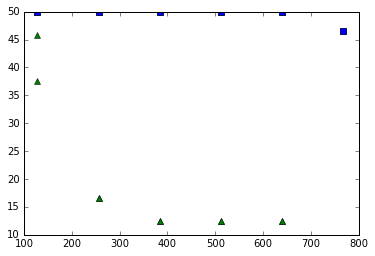

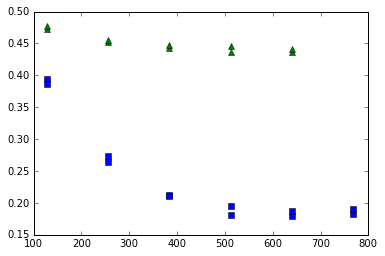

In [14]:
#analysis.print_statistics(mtg_sweep1['baseline_128_1'])
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def size_from_name(cp_name):
    return int(cp_name.split('_')[-2])

mtg_sizes = [size_from_name(cp) for cp in mtg_sweep1 if 'baseline' in cp]
char_sizes = [size_from_name(cp) for cp in char_sweep1 if 'baseline' in cp]

mtg_epochs = [mtg_sweep1[cp]['cp']['epoch'] for cp in mtg_sweep1 if 'baseline' in cp]
char_epochs = [char_sweep1[cp]['cp']['epoch'] for cp in char_sweep1 if 'baseline' in cp]

mtg_vlosses = [mtg_sweep1[cp]['cp']['vloss'] for cp in mtg_sweep1 if 'baseline' in cp]
char_vlosses = [char_sweep1[cp]['cp']['vloss'] for cp in char_sweep1 if 'baseline' in cp]

#fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(mtg_sizes, mtg_epochs, 'bs', char_sizes, char_epochs, 'g^')
#fig.show()

plt.plot(mtg_sizes, mtg_epochs, 'bs', char_sizes, char_epochs, 'g^')
plt.show()

plt.plot(mtg_sizes, mtg_vlosses, 'bs', char_sizes, char_vlosses, 'g^')
plt.show()